In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
from pathlib import Path
from collections import Counter

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import dill
import pandas as pd
import polars as pl
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import GroupKFold

import lightgbm as lgb
import xgboost as xgb

import pytorch_lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from tasks.data.dataset.mappers import EntityEncoder
from tasks.jobs import Splitter

In [3]:
from otto_utils import *
from otto_features import *
from otto_candidates_covisit import *
from otto_lgbm_utils import *
from otto_implicit import *
from otto_reranker import *

In [4]:
%env PYTHONHASHSEED=1
from otto_word2vec import *

w2vec = Word2Vec.load("__valid__word2vec_window=10_negative=20.w2v")

env: PYTHONHASHSEED=1


# Load data

In [5]:
# load
val_df_train = pl.read_parquet(VALIDATION_PATH / "train.parquet", use_pyarrow=True)
val_df_valid_input = pl.read_parquet(VALIDATION_PATH / "valid.parquet", use_pyarrow=True)
val_df_valid_targets = pl.read_parquet(VALIDATION_PATH / "test_labels.parquet", use_pyarrow=True)

# Features

In [6]:
df = val_df_valid_input.unique().sort(["session", "ts"])

In [9]:
df_user_recent_actions = (
    df
    .groupby(["session"])
    .agg([
        pl.list("aid")
    ])
    .select([
        pl.col("session"),
        pl.col("aid").arr.get(-1).alias("t_0_recent"),
        pl.col("aid").arr.get(-2).alias("t_-1_recent"),
        pl.col("aid").arr.get(-3).alias("t_-2_recent"),
        pl.col("aid").arr.get(-4).alias("t_-3_recent"),
        pl.col("aid").arr.get(-5).alias("t_-4_recent"),
    ])
    .sort("session")
)

In [10]:
df_user_recent_actions

session,t_0_recent,t_-1_recent,t_-2_recent,t_-3_recent,t_-4_recent
i64,i64,i64,i64,i64,i64
11107743,1243310,731062,1243310,null,null
11107744,1556644,1637748,1556644,220086,null
11107745,670066,1682122,670066,1682122,1682122
11107746,795232,1134602,null,null,null
11107747,618078,1368814,543120,13046,1006198
11107748,1154005,null,null,null,null
11107749,636540,153565,null,null,null
11107750,728766,37995,null,null,null
11107754,1438446,null,null,null,null


In [11]:
df_user_last_type_actions = (
    df
    .groupby(["session", "type"])
    .agg([
        pl.last("aid")
    ])
    .pivot(values="aid", index="session", columns="type")
    .rename({
        "0": "last_click_aid",
        "1": "last_cart_aid",
        "2": "last_order_aid",
    })
    .sort("session")
)

In [12]:
df_user_action_stats_features = pl.read_parquet("__features__valid__user_action_stats_v1.parquet")
df_user_item_history_features = pl.read_parquet("__features__valid__user_item_history_v1.parquet")
df_user_last_type_actions = pl.read_parquet("__features__valid__user_last_type_actions_v1.parquet")
df_item_action_stats_features = pl.read_parquet("__features__valid__item_action_stats_v1.parquet")
df_item_n_sess_multiple_action = pl.read_parquet("__features__valid__item_n_sess_multiple_action_v1.parquet")

# Candidates

In [13]:
ACT_TYPE = "orders"

## prepare target and candidates set with this target in holdout (other users for action does not change metric)

In [14]:
df_act_target = (
    val_df_valid_targets
    .filter(pl.col("type") == ACT_TYPE)
    .join(val_df_valid_input.select(["session"]).unique(), on="session", how="inner")
    .drop("type")
    .explode("ground_truth")
    .with_column(pl.lit(1).alias("target"))
    .rename({"ground_truth": "aid"})
)

In [15]:
df = val_df_valid_input.unique().sort(["session", "ts"])

In [16]:
df_test_users = (
    df
    .join(df_act_target.select(["session"]).unique(), on="session", how="inner")
    .unique().sort(["session", "ts"])
)
test_sessions_dict = df_test_users.groupby('session').agg([pl.list("aid"), pl.list("type")])
test_sessions_dict = dict(zip(
    test_sessions_dict["session"].to_list(),
    tuple(zip(test_sessions_dict["aid"].to_list(), test_sessions_dict["type"].to_list()))
))

## covisitation top200

In [17]:
# Use top X for clicks, carts and orders
clicks_th = 15
carts_th  = 20
orders_th = 20

def get_top(df, th):
    return (
        df
        .with_column(pl.lit(1).alias("ones"))
        .with_column(pl.col("ones").cumsum().over("aid").alias("rank"))
        .filter(pl.col("rank") <= th)
    )

TOPK_RECOMMEND = 20
TOPK_RERANK = 40

In [18]:
carts_orders = pl.read_parquet("__valid__covisit_carts_orders_all_v3.parquet")
buys2buys = pl.read_parquet("__valid__covisit_buys2buys_all_v4.parquet")
clicks = pl.read_parquet("__valid__covisit_clicks_all_v3.parquet")

In [19]:
carts_orders_top = get_top(carts_orders, carts_th)
buys2buys_top = get_top(buys2buys, orders_th)
clicks_top = get_top(clicks, clicks_th)

In [20]:
top_clicks = df.filter(pl.col("type") == 0)["aid"].value_counts(sort=True)[:TOPK_RECOMMEND]["aid"].to_list()
top_carts = df.filter(pl.col("type") == 1)["aid"].value_counts(sort=True)[:TOPK_RECOMMEND]["aid"].to_list()
top_orders = df.filter(pl.col("type") == 2)["aid"].value_counts(sort=True)[:TOPK_RECOMMEND]["aid"].to_list()

In [21]:
covisit_rec = CovisitationRecommender(
    df_top_k_buys=carts_orders_top,
    df_top_k_buy2buy=buys2buys_top,
    df_top_k_clicks=clicks_top,
    top_carts=top_carts,
    top_orders=top_orders,
    top_clicks=top_clicks,
)

In [22]:
candidates_dict = {
    "session": [],
    "type": [],
    "candidates": [],
    "rank": [],
}

types = ["clicks", "carts", "orders"]
topk = TOPK_RERANK * 5

for session_id, (session_aid_list, session_type_list) in tqdm(test_sessions_dict.items()):
    rec_items_clicks = covisit_rec.recommend_clicks(session_aid_list, session_type_list, topk)
    rec_items_carts = covisit_rec.recommend_carts(session_aid_list, session_type_list, topk)
    rec_items_buys = covisit_rec.recommend_buys(session_aid_list, session_type_list, topk)

    candidates = [rec_items_clicks, rec_items_carts, rec_items_buys]
#     candidates = [rec_items_buys]
    ranks = [
        np.arange(1, len(rec_items) + 1).tolist()
        for rec_items in candidates
    ]
    
    candidates_dict["session"].extend([session_id] * len(types))
    candidates_dict["type"].extend(types)
    candidates_dict["candidates"].extend(candidates)
    candidates_dict["rank"].extend(ranks)

df_candidates_covisit = pl.DataFrame(candidates_dict)

100%|██████████| 134666/134666 [00:18<00:00, 7135.81it/s]


## implicit i2i k=100 top100

In [23]:
from implicit.nearest_neighbours import CosineRecommender
from implicit.nearest_neighbours import TFIDFRecommender

### old weights

In [24]:
df = pl.concat([val_df_train, val_df_valid_input]).unique().sort(["session", "ts"])
df = implicit_old_weight_interactions(df)

In [25]:
train_data = make_sparse_matrix(df)
i2i_old = CosineRecommender(K=100)
i2i_old.fit(train_data)

  0%|          | 0/1855603 [00:00<?, ?it/s]

In [26]:
df_candidates_i2i_old = implicit_batch_candidates_for_all_types(
    model=i2i_old, model_name="i2i_old",
    train_data=train_data, test_users=list(test_sessions_dict.keys()),
    topk=100,
)

100%|██████████| 135/135 [00:12<00:00, 10.89it/s]


### new weights

In [27]:
df = pl.concat([val_df_train, val_df_valid_input]).unique().sort(["session", "ts"])
df = implicit_new_weight_interactions(df)

In [28]:
train_data = make_sparse_matrix(df)
i2i_new = CosineRecommender(K=100)
i2i_new.fit(train_data)

  0%|          | 0/1855603 [00:00<?, ?it/s]

In [29]:
df_candidates_i2i_new = implicit_batch_candidates_for_all_types(
    model=i2i_new, model_name="i2i_new",
    train_data=train_data, test_users=list(test_sessions_dict.keys()),
    topk=100,
)

100%|██████████| 135/135 [00:15<00:00,  8.77it/s]


### tfidf - old

In [84]:
df = pl.concat([val_df_train, val_df_valid_input]).unique().sort(["session", "ts"])
df = implicit_old_weight_interactions(df)

In [85]:
train_data = make_sparse_matrix(df)
tfidf_old = TFIDFRecommender(K=200)
tfidf_old.fit(train_data)

  0%|          | 0/1855603 [00:00<?, ?it/s]

In [86]:
df_candidates_tfidf_old = implicit_batch_candidates_for_all_types(
    model=tfidf_old, model_name="tfidf_old",
    train_data=train_data, test_users=list(test_sessions_dict.keys()),
    topk=100,
)

100%|██████████| 135/135 [00:15<00:00,  8.91it/s]


#### recall top100

In [82]:
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"]
topk = 200

test_users = val_df_valid_input["session"].unique().to_list()
b_sz = 1000
recs = []
for test_session_start in tqdm(range(0, len(test_users), b_sz)):
    test_sessions = test_users[test_session_start : test_session_start + b_sz]
    rec_items, scores = tfidf_new.recommend(
        test_sessions, user_items=train_data[test_sessions], N=topk,
        filter_already_liked_items=False, recalculate_user=False
    )
    session_types = [
        [f"{session_id}_{t}" for t in types]
        for session_id in test_sessions
    ]
    labels_list = [
        [" ".join(str(aid) for aid in recs.tolist())] * 3
        for recs in rec_items
    ]
    
    submission_dict["session_type"].extend(itertools.chain(*session_types))
    submission_dict["labels"].extend(itertools.chain(*labels_list))
    
df_submission_tfidf_i2i = pl.DataFrame(submission_dict)

100%|██████████| 1304/1304 [02:21<00:00,  9.24it/s]


In [76]:
# k=200, topk=20
_ = calc_valid_score(df_submission_tfidf_i2i, topk=topk)

validation score: 0.5370271735299936
recall per type: type
carts    0.3749
clicks   0.4806
orders   0.6275
dtype: float64


In [78]:
# k=200, topk=100
_ = calc_valid_score(df_submission_tfidf_i2i, topk=topk)

validation score: 0.6035364855707382
recall per type: type
carts    0.4561
clicks   0.5950
orders   0.6787
dtype: float64


In [81]:
# k=400, topk=100
_ = calc_valid_score(df_submission_tfidf_i2i, topk=topk)

validation score: 0.6035364855707382
recall per type: type
carts    0.4561
clicks   0.5950
orders   0.6787
dtype: float64


In [83]:
# k=400, topk=200
_ = calc_valid_score(df_submission_tfidf_i2i, topk=topk)

validation score: 0.6258221868420739
recall per type: type
carts    0.4864
clicks   0.6228
orders   0.6960
dtype: float64


### tfidf - new

In [116]:
df = pl.concat([val_df_train, val_df_valid_input]).unique().sort(["session", "ts"])
df = implicit_new_weight_interactions(df)

In [117]:
train_data = make_sparse_matrix(df)
tfidf_new = TFIDFRecommender(K=200)
tfidf_new.fit(train_data)

  0%|          | 0/1855603 [00:00<?, ?it/s]

In [118]:
df_candidates_tfidf_new = implicit_batch_candidates_for_all_types(
    model=tfidf_new, model_name="tfidf_new",
    train_data=train_data, test_users=list(test_sessions_dict.keys()),
    topk=100,
)

100%|██████████| 135/135 [00:14<00:00,  9.60it/s]


In [135]:
df_candidates_tfidf_new = implicit_batch_candidates_for_all_types(
    model=tfidf_new, model_name="tfidf_new",
    train_data=train_data, test_users=list(test_sessions_dict.keys()),
    topk=200,
)

100%|██████████| 135/135 [00:15<00:00,  8.62it/s]


#### recall top100

In [133]:
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"]
topk = 200

test_users = val_df_valid_input["session"].unique().to_list()
b_sz = 1000
recs = []
for test_session_start in tqdm(range(0, len(test_users), b_sz)):
    test_sessions = test_users[test_session_start : test_session_start + b_sz]
    rec_items, scores = tfidf_new.recommend(
        test_sessions, user_items=train_data[test_sessions], N=topk,
        filter_already_liked_items=False, recalculate_user=False
    )
    session_types = [
        [f"{session_id}_{t}" for t in types]
        for session_id in test_sessions
    ]
    labels_list = [
        [" ".join(str(aid) for aid in recs.tolist())] * 3
        for recs in rec_items
    ]
    
    submission_dict["session_type"].extend(itertools.chain(*session_types))
    submission_dict["labels"].extend(itertools.chain(*labels_list))
    
df_submission_tfidf_i2i = pl.DataFrame(submission_dict)

100%|██████████| 1304/1304 [02:25<00:00,  8.93it/s]


In [72]:
# k=100, topk=20
_ = calc_valid_score(df_submission_tfidf_i2i, topk=topk)

validation score: 0.526898277292816
recall per type: type
carts    0.3765
clicks   0.4798
orders   0.6099
dtype: float64


In [69]:
# k=100, topk=50
_ = calc_valid_score(df_submission_tfidf_i2i, topk=topk)

validation score: 0.5720508244015889
recall per type: type
carts    0.4229
clicks   0.5501
orders   0.6503
dtype: float64


In [67]:
# k=100, topk=100
_ = calc_valid_score(df_submission_tfidf_i2i, topk=topk)

validation score: 0.6006943282201418
recall per type: type
carts    0.4568
clicks   0.5960
orders   0.6735
dtype: float64


In [64]:
# k=200, topk=100
_ = calc_valid_score(df_submission_tfidf_i2i, topk=topk)

validation score: 0.6039219074328852
recall per type: type
carts    0.4607
clicks   0.6006
orders   0.6761
dtype: float64


In [134]:
# k=200, topk=200
_ = calc_valid_score(df_submission_tfidf_i2i, topk=topk)

validation score: 0.6303590805475656
recall per type: type
carts    0.4939
clicks   0.6425
orders   0.6966
dtype: float64


### combined recall old top100 + new top100

In [131]:
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"][2:]
topk = 200

test_users = list(test_sessions_dict.keys())

for test_session in tqdm(range(0, len(test_users))):
    session_id = df_candidates_tfidf_new[test_session, 0]
    aid_old = df_candidates_tfidf_old[test_session, 1].to_list()
    aid_new = df_candidates_tfidf_new[test_session, 1].to_list()
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels_list = [" ".join(str(aid) for aid in aid_old + aid_new)] * len(types)
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)
    
df_submission_tfidf_i2i = pl.DataFrame(submission_dict)

100%|██████████| 134666/134666 [00:37<00:00, 3562.88it/s]


In [132]:
# k=200, topk=100 + 100
_ = calc_valid_score(df_submission_tfidf_i2i, topk=topk)

validation score: 0.41521658632133746
recall per type: type
orders   0.6920
dtype: float64


# Reranker

## tfidf candidates

In [137]:
df_candidates_all = (
    df_candidates_covisit
    .filter(pl.col("type") == "orders")
    .drop("type")
    .explode(["candidates", "rank"])
    .rename({"candidates": "aid", "rank": "rank_orders"})
    .join(
        (
            df_candidates_covisit
            .filter(pl.col("type") == "carts")
            .drop("type")
            .explode(["candidates", "rank"])
            .rename({"candidates": "aid", "rank": "rank_carts"})
        ),
        on=["session", "aid"],
        how="outer"
    )
    .join(
        (
            df_candidates_covisit
            .filter(pl.col("type") == "clicks")
            .drop("type")
            .explode(["candidates", "rank"])
            .rename({"candidates": "aid", "rank": "rank_clicks"})
        ),
        on=["session", "aid"],
        how="outer"
    )
    .join(
        (
            df_candidates_tfidf_new
            .explode(["aid", "tfidf_new_score"])
        ),
        on=["session", "aid"],
        how="outer"
    )
    .fill_null(999)
    .filter(pl.col("aid") != -1)  # some strange items from implicit
    .unique(subset=["session", "aid"], keep="last")
    .join(df_act_target, on=["session", "aid"], how="left")  # if using rank column as a feature
    .sort("session")
    .fill_null(0)
)

In [138]:
df_candidates_all

session,aid,rank_orders,rank_carts,rank_clicks,tfidf_new_score,target
i64,i64,i64,i64,i64,f64,i32
11107757,1477337,999,999,999,0.020702,0
11107757,1643208,999,999,999,0.020821,0
11107757,736420,999,999,999,0.020717,0
11107757,896158,999,999,999,0.021307,0
11107757,908162,999,999,999,0.020912,0
11107757,40508,999,999,999,0.02072,0
11107757,1095008,999,999,999,0.020964,0
11107757,555316,999,999,999,0.021612,0
11107757,1025097,999,999,999,0.021874,0


In [155]:
df_sessions_with_positives = (
    df_candidates_all.groupby(["session"]).agg(pl.sum("target"))
    .filter(pl.col("target") > 0)
    .select(["session"])
)

In [156]:
print("sessions with positives in candidates: ", df_sessions_with_positives["session"].n_unique())
print("sessions with positives in test dataframe: ", df_candidates_all["session"].n_unique())
print(
    "hit rate: ", 
    df_sessions_with_positives["session"].n_unique() / df_candidates_all["session"].n_unique()
)

sessions with positives in candidates:  120886
sessions with positives in test dataframe:  134666
hit rate:  0.8976727607562414


In [157]:
df_candidates_with_positives = (
    df_candidates_all
    .join(df_sessions_with_positives, on="session", how="inner")
)

In [158]:
df_candidates_with_positives["target"].value_counts()

target,counts
i32,u32
0,35452430
1,209477


In [139]:
df_candidates_all["target"].value_counts()

target,counts
i32,u32
0,39363243
1,209477


In [89]:
df_candidates_all

session,aid,rank_orders,rank_carts,rank_clicks,tfidf_old_score,target
i64,i64,i64,i64,i64,f64,i32
11107757,69701,1,1,1,10.513677,1
11107757,441214,2,2,2,10.513677,0
11107757,1522691,3,3,3,1.426476,0
11107757,1777631,4,4,4,2.174507,0
11107757,416657,6,5,18,1.256359,0
11107757,1285692,7,6,20,0.852704,0
11107757,1355234,13,7,6,999.0,0
11107757,721908,8,8,7,2.014914,0
11107757,457354,11,9,8,999.0,0


In [90]:
df_candidates_all["target"].value_counts()

target,counts
i32,u32
0,26898988
1,207219


## old candidates

In [30]:
df_candidates_all = (
    df_candidates_covisit
    .filter(pl.col("type") == "orders")
    .drop("type")
    .explode(["candidates", "rank"])
    .rename({"candidates": "aid", "rank": "rank_orders"})
    .join(
        (
            df_candidates_covisit
            .filter(pl.col("type") == "carts")
            .drop("type")
            .explode(["candidates", "rank"])
            .rename({"candidates": "aid", "rank": "rank_carts"})
        ),
        on=["session", "aid"],
        how="outer"
    )
    .join(
        (
            df_candidates_covisit
            .filter(pl.col("type") == "clicks")
            .drop("type")
            .explode(["candidates", "rank"])
            .rename({"candidates": "aid", "rank": "rank_clicks"})
        ),
        on=["session", "aid"],
        how="outer"
    )
    .join(
        (
            df_candidates_i2i_new
            .explode(["aid", "i2i_new_score"])
        ),
        on=["session", "aid"],
        how="outer"
    )
    .join(
        (
            df_candidates_i2i_old
            .explode(["aid", "i2i_old_score"])
        ),
        on=["session", "aid"],
        how="outer"
    )
    .fill_null(999)
    .filter(pl.col("aid") != -1)  # some strange items from implicit
    .unique(subset=["session", "aid"], keep="last")
    .join(df_act_target, on=["session", "aid"], how="left")  # if using rank column as a feature
    .sort("session")
    .fill_null(0)
)

## Features

In [142]:
df_cand_w2v_recent_item_features = cand_w2v_recent_item_features(
    df_candidates_all.select(["session", "aid"]),
    df_user_recent_actions,
    w2vec
)

100%|██████████| 5/5 [02:07<00:00, 25.54s/it]


In [143]:
df_cand_recent_item_to_item_features = cand_recent_item_to_item_features(
    df_candidates_all.select(["session", "aid"]),
    df_user_recent_actions,
    df_carts_orders=carts_orders,
    df_buys2buys=buys2buys,
    df_clicks=clicks
)

In [144]:
df_cand_w2v_features = cand_w2v_features(
    df_candidates_all.select(["session", "aid"]),
    df_user_last_type_actions,
    w2vec
)

In [145]:
df_item_to_item_features = cand_item_to_item_features(
    df_candidates_all.select(["session", "aid"]),
    df_user_last_type_actions,
    df_carts_orders=carts_orders,
    df_buys2buys=buys2buys,
    df_clicks=clicks
)

In [146]:
df_other_features = cand_other_features(
    df_candidates_all.select(["session", "aid"]),
    df_user_action_stats_features,
    df_item_action_stats_features,
    df_item_n_sess_multiple_action,
    df_user_item_history_features,
)

In [147]:
df_stage_2_dataset = (
    df_candidates_all
    .join(df_cand_w2v_features, on=["session", "aid"], how="left")
    .join(df_cand_w2v_recent_item_features, on=["session", "aid"], how="left")
    .join(df_item_to_item_features, on=["session", "aid"], how="left")
    .join(df_cand_recent_item_to_item_features, on=["session", "aid"], how="left")
    .join(df_other_features, on=["session", "aid"], how="left")
    .fill_null(0)
)

## Train

### TFIDFRecommender (k=200, top200) - new

In [150]:
df_stage_2_dataset.head()

session,aid,rank_orders,rank_carts,rank_clicks,tfidf_new_score,target,w2v_cosine_sim_last_click_aid,w2v_cosine_sim_last_cart_aid,w2v_cosine_sim_last_order_aid,w2v_cosine_sim_t_0_recent,w2v_cosine_sim_t_-1_recent,w2v_cosine_sim_t_-2_recent,w2v_cosine_sim_t_-3_recent,w2v_cosine_sim_t_-4_recent,user_last_click_aid_carts_orders_weight,user_last_click_aid_buy2buy_weight,user_last_click_aid_click_weight,user_last_cart_aid_carts_orders_weight,user_last_cart_aid_buy2buy_weight,user_last_cart_aid_click_weight,user_last_order_aid_carts_orders_weight,user_last_order_aid_buy2buy_weight,user_last_order_aid_click_weight,user_t_0_recent_carts_orders_weight,user_t_-1_recent_carts_orders_weight,user_t_-2_recent_carts_orders_weight,user_t_-3_recent_carts_orders_weight,user_t_-4_recent_carts_orders_weight,user_t_0_recent_buy2buy_weight,user_t_-1_recent_buy2buy_weight,user_t_-2_recent_buy2buy_weight,user_t_-3_recent_buy2buy_weight,user_t_-4_recent_buy2buy_weight,user_t_0_recent_click_weight,user_t_-1_recent_click_weight,user_t_-2_recent_click_weight,user_t_-3_recent_click_weight,user_t_-4_recent_click_weight,user_lifetime_days,user_n_actions,user_n_uniq_items,user_buys_rate,user_uniq_clicks,user_uniq_carts,user_uniq_orders,cl_cnt,ca_cnt,or_cnt,user_ca_cl_ratio,user_or_cl_ratio,user_or_ca_ratio,item_lifetime_days,item_n_actions,item_n_uniq_users,item_buys_rate,item_uniq_clicks,item_uniq_orders,item_uniq_carts,cl_cnt_right,or_cnt_right,ca_cnt_right,item_ca_cl_ratio,item_or_cl_ratio,item_or_ca_ratio,item_n_sess_multi_clicks,item_n_sess_multi_carts,item_n_sess_multi_buys,user_item_log_recency_score,user_item_type_weighted_log_recency_score,user_item_is_in_history
i64,i64,i64,i64,i64,f64,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64,f64,i32,f64,f64,i32,f64,f64,f64,f64,f64,f64,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,u32,u32,f64,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64,u32,u32,f64,u32,u32,u32,u32,u32,u32,f64,f64,f64,u32,u32,u32,f64,f64,i32
11107757,1477337,999,999,999,0.020702,0,0.921452,-999.0,-999.0,0.921452,0.861828,-999.0,-999.0,-999.0,0.5,0,1.298915,0.0,0,0.0,0.0,0,0.0,0.5,0.0,0.0,0.0,0.0,0,0,0,0,0,1.298915,0.0,0.0,0.0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,21.130225,12,1,0.0,11,0,0,12,0,0,0.0,0.0,0.0,1,0,0,0.0,0.0,0
11107757,1643208,999,999,999,0.020821,0,0.822969,-999.0,-999.0,0.822969,0.788223,-999.0,-999.0,-999.0,0.5,0,3.186593,0.0,0,0.0,0.0,0,0.0,0.5,0.5,0.0,0.0,0.0,0,0,0,0,0,3.186593,3.186593,0.0,0.0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,24.494925,89,1,0.011236,58,0,1,88,0,1,0.011364,0.0,0.0,15,0,0,0.0,0.0,0
11107757,736420,999,999,999,0.020717,0,0.820906,-999.0,-999.0,0.820906,0.837451,-999.0,-999.0,-999.0,0.5,0,1.062582,0.0,0,0.0,0.0,0,0.0,0.5,0.5,0.0,0.0,0.0,0,0,0,0,0,1.062582,2.49946,0.0,0.0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,13.41085,5,1,0.0,5,0,0,5,0,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0
11107757,896158,999,999,999,0.021307,0,0.458267,-999.0,-999.0,0.458267,0.536822,-999.0,-999.0,-999.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,20.183936,9,1,0.0,8,0,0,9,0,0,0.0,0.0,0.0,1,0,0,0.0,0.0,0
11107757,908162,999,999,999,0.020912,0,0.639259,-999.0,-999.0,0.639259,0.74872,-999.0,-999.0,-999.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,25.954779,35,1,0.0,32,0,0,35,0,0,0.0,0.0,0.0,3,0,0,0.0,0.0,0


In [151]:
feature_cols = df_stage_2_dataset.drop(["session", "aid", "target"]).columns
print("num features: ", len(feature_cols))

num features:  68


In [152]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
#     'objective': 'binary',
    'objective': 'lambdarank',
    'metric': '"None"',
    'eval_at': 20,
#     'metric': {'auc', 'binary_logloss'},
#     'min_data_in_leaf': 256, 
#     'num_leaves': 63,
    'max_depth': 7,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'device': 'gpu',
    'verbose': -1,
    'num_threads': 40,
}

In [153]:
skf = GroupKFold(n_splits=5)
df_valid_preds = df_candidates_all.select(["session", "aid"])

for fold, (train_idx, valid_idx) in tqdm(enumerate(
    skf.split(df_stage_2_dataset,
              df_stage_2_dataset['target'],
              groups=df_stage_2_dataset['session'])
)):
    
    # contains sessions with no positives
    X_train = df_stage_2_dataset[train_idx][feature_cols].to_pandas()
    y_train = df_stage_2_dataset[train_idx]["target"].to_pandas()
    X_valid = df_stage_2_dataset[valid_idx][feature_cols].to_pandas()
    y_valid = df_stage_2_dataset[valid_idx]["target"].to_pandas()
    
    # create dataset for lightgbm
    groups_len_train = (
        df_stage_2_dataset[train_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )
    groups_len_valid = (
        df_stage_2_dataset[valid_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )    
    lgb_train = lgb.Dataset(X_train, y_train, group=groups_len_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, group=groups_len_valid, reference=lgb_train)
    
    # train model
    gbm_ranking = lgb.train(
        params, 
        lgb_train,
        num_boost_round=2000,
#         return_cvbooster=True,
        feval=lgb_numba_recall,
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=20)]
    )
    
    scores = gbm_ranking.predict(X_valid)
    df_valid_preds_fold = (
        df_stage_2_dataset[valid_idx].select(["session", "aid"])
        .with_columns([pl.Series(scores).alias(f"scores_fold{fold}")])
    )
    df_valid_preds = (
        df_valid_preds.join(df_valid_preds_fold, on=["session", "aid"], how="left")
    )
    
    # add save models
    gbm_ranking.save_model(
        f"__model__{ACT_TYPE}_covisit_all_types_merged_top200+tfidf_new_k=200_top200_reranker_69feat_fold{fold}.lgb"
    )

0it [00:00, ?it/s]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.894051
[40]	valid_0's numba_recall@20: 0.89638
[60]	valid_0's numba_recall@20: 0.89794
[80]	valid_0's numba_recall@20: 0.899092
[100]	valid_0's numba_recall@20: 0.900269
[120]	valid_0's numba_recall@20: 0.900821
[140]	valid_0's numba_recall@20: 0.901037
[160]	valid_0's numba_recall@20: 0.901229
[180]	valid_0's numba_recall@20: 0.901061
[200]	valid_0's numba_recall@20: 0.901445
[220]	valid_0's numba_recall@20: 0.901589
[240]	valid_0's numba_recall@20: 0.901949
[260]	valid_0's numba_recall@20: 0.902142
[280]	valid_0's numba_recall@20: 0.901853
[300]	valid_0's numba_recall@20: 0.901925
[320]	valid_0's numba_recall@20: 0.902166
[340]	valid_0's numba_recall@20: 0.902502
[360]	valid_0's numba_recall@20: 0.90243
[380]	valid_0's numba_recall@20: 0.902454
[400]	valid_0's numba_recall@20: 0.902838
[420]	valid_0's numba_recall@20: 0.902742
[440]	valid_0's numba_recall@20: 0.902934
[460]	valid_0's numba

1it [09:21, 561.62s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.896864
[40]	valid_0's numba_recall@20: 0.900086
[60]	valid_0's numba_recall@20: 0.902544
[80]	valid_0's numba_recall@20: 0.90357
[100]	valid_0's numba_recall@20: 0.904477
[120]	valid_0's numba_recall@20: 0.905264
[140]	valid_0's numba_recall@20: 0.905885
[160]	valid_0's numba_recall@20: 0.905861
[180]	valid_0's numba_recall@20: 0.906004
[200]	valid_0's numba_recall@20: 0.90629
[220]	valid_0's numba_recall@20: 0.906076
[240]	valid_0's numba_recall@20: 0.906123
[260]	valid_0's numba_recall@20: 0.906338
[280]	valid_0's numba_recall@20: 0.906911
[300]	valid_0's numba_recall@20: 0.906648
[320]	valid_0's numba_recall@20: 0.906505
[340]	valid_0's numba_recall@20: 0.906314
[360]	valid_0's numba_recall@20: 0.906648
Early stopping, best iteration is:
[278]	valid_0's numba_recall@20: 0.906982


2it [13:42, 384.54s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.895771
[40]	valid_0's numba_recall@20: 0.898995
[60]	valid_0's numba_recall@20: 0.901215
[80]	valid_0's numba_recall@20: 0.902696
[100]	valid_0's numba_recall@20: 0.903961
[120]	valid_0's numba_recall@20: 0.904893
[140]	valid_0's numba_recall@20: 0.90549
[160]	valid_0's numba_recall@20: 0.905919
[180]	valid_0's numba_recall@20: 0.906278
[200]	valid_0's numba_recall@20: 0.906397
[220]	valid_0's numba_recall@20: 0.906803
[240]	valid_0's numba_recall@20: 0.907018
[260]	valid_0's numba_recall@20: 0.906827
[280]	valid_0's numba_recall@20: 0.907328
[300]	valid_0's numba_recall@20: 0.907376
[320]	valid_0's numba_recall@20: 0.907567
[340]	valid_0's numba_recall@20: 0.907877
[360]	valid_0's numba_recall@20: 0.907877
[380]	valid_0's numba_recall@20: 0.90783
[400]	valid_0's numba_recall@20: 0.907806
[420]	valid_0's numba_recall@20: 0.907615
[440]	valid_0's numba_recall@20: 0.90771
Early stopping, best 

3it [18:46, 347.86s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.899074
[40]	valid_0's numba_recall@20: 0.902192
[60]	valid_0's numba_recall@20: 0.904278
[80]	valid_0's numba_recall@20: 0.905213
[100]	valid_0's numba_recall@20: 0.906364
[120]	valid_0's numba_recall@20: 0.906628
[140]	valid_0's numba_recall@20: 0.906796
[160]	valid_0's numba_recall@20: 0.907203
[180]	valid_0's numba_recall@20: 0.907203
[200]	valid_0's numba_recall@20: 0.907419
[220]	valid_0's numba_recall@20: 0.907419
[240]	valid_0's numba_recall@20: 0.908138
[260]	valid_0's numba_recall@20: 0.908066
[280]	valid_0's numba_recall@20: 0.908282
[300]	valid_0's numba_recall@20: 0.90809
[320]	valid_0's numba_recall@20: 0.908162
[340]	valid_0's numba_recall@20: 0.908402
[360]	valid_0's numba_recall@20: 0.908474
[380]	valid_0's numba_recall@20: 0.90857
[400]	valid_0's numba_recall@20: 0.908642
[420]	valid_0's numba_recall@20: 0.908354
[440]	valid_0's numba_recall@20: 0.908354
[460]	valid_0's numb

4it [24:14, 339.90s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.894444
[40]	valid_0's numba_recall@20: 0.897119
[60]	valid_0's numba_recall@20: 0.899676
[80]	valid_0's numba_recall@20: 0.901025
[100]	valid_0's numba_recall@20: 0.902232
[120]	valid_0's numba_recall@20: 0.902942
[140]	valid_0's numba_recall@20: 0.903227
[160]	valid_0's numba_recall@20: 0.903653
[180]	valid_0's numba_recall@20: 0.904102
[200]	valid_0's numba_recall@20: 0.904126
[220]	valid_0's numba_recall@20: 0.904197
[240]	valid_0's numba_recall@20: 0.904434
[260]	valid_0's numba_recall@20: 0.904458
[280]	valid_0's numba_recall@20: 0.904481
[300]	valid_0's numba_recall@20: 0.904718
[320]	valid_0's numba_recall@20: 0.90486
[340]	valid_0's numba_recall@20: 0.904884
[360]	valid_0's numba_recall@20: 0.904694
[380]	valid_0's numba_recall@20: 0.904576
[400]	valid_0's numba_recall@20: 0.904576
[420]	valid_0's numba_recall@20: 0.904529
Early stopping, best iteration is:
[332]	valid_0's numba_reca

5it [29:04, 348.91s/it]


In [154]:
_ = calc_oof_score_for_type(df_valid_preds, act_type="orders")

100%|██████████| 134666/134666 [00:00<00:00, 269025.41it/s]


validation score: 0.39499625343435185
recall per type: type
orders   0.6583
dtype: float64


### TFIDFRecommender (k=200, top100) - old

In [111]:
df_stage_2_dataset.head()

session,aid,rank_orders,rank_carts,rank_clicks,tfidf_old_score,target,w2v_cosine_sim_last_click_aid,w2v_cosine_sim_last_cart_aid,w2v_cosine_sim_last_order_aid,w2v_cosine_sim_t_0_recent,w2v_cosine_sim_t_-1_recent,w2v_cosine_sim_t_-2_recent,w2v_cosine_sim_t_-3_recent,w2v_cosine_sim_t_-4_recent,user_last_click_aid_carts_orders_weight,user_last_click_aid_buy2buy_weight,user_last_click_aid_click_weight,user_last_cart_aid_carts_orders_weight,user_last_cart_aid_buy2buy_weight,user_last_cart_aid_click_weight,user_last_order_aid_carts_orders_weight,user_last_order_aid_buy2buy_weight,user_last_order_aid_click_weight,user_t_0_recent_carts_orders_weight,user_t_-1_recent_carts_orders_weight,user_t_-2_recent_carts_orders_weight,user_t_-3_recent_carts_orders_weight,user_t_-4_recent_carts_orders_weight,user_t_0_recent_buy2buy_weight,user_t_-1_recent_buy2buy_weight,user_t_-2_recent_buy2buy_weight,user_t_-3_recent_buy2buy_weight,user_t_-4_recent_buy2buy_weight,user_t_0_recent_click_weight,user_t_-1_recent_click_weight,user_t_-2_recent_click_weight,user_t_-3_recent_click_weight,user_t_-4_recent_click_weight,user_lifetime_days,user_n_actions,user_n_uniq_items,user_buys_rate,user_uniq_clicks,user_uniq_carts,user_uniq_orders,cl_cnt,ca_cnt,or_cnt,user_ca_cl_ratio,user_or_cl_ratio,user_or_ca_ratio,item_lifetime_days,item_n_actions,item_n_uniq_users,item_buys_rate,item_uniq_clicks,item_uniq_orders,item_uniq_carts,cl_cnt_right,or_cnt_right,ca_cnt_right,item_ca_cl_ratio,item_or_cl_ratio,item_or_ca_ratio,item_n_sess_multi_clicks,item_n_sess_multi_carts,item_n_sess_multi_buys,user_item_log_recency_score,user_item_type_weighted_log_recency_score,user_item_is_in_history
i64,i64,i64,i64,i64,f64,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64,f64,i32,f64,f64,i32,f64,f64,f64,f64,f64,f64,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,u32,u32,f64,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64,u32,u32,f64,u32,u32,u32,u32,u32,u32,f64,f64,f64,u32,u32,u32,f64,f64,i32
11107757,69701,1,1,1,10.513677,1,1.0,-999.0,-999.0,1.0,0.937693,-999.0,-999.0,-999.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,8.0,0.0,0.0,0.0,0,0,0,0,0,0.0,37.502685,0.0,0.0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,26.755954,422,1,0.042654,299,2,9,406,2,14,0.034483,0.004926,0.142857,63,1,0,1.0,1.0,1
11107757,441214,2,2,2,10.513677,0,0.937693,-999.0,-999.0,0.937693,1.0,-999.0,-999.0,-999.0,8.5,0,39.636885,0.0,0,0.0,0.0,0,0.0,8.5,0.0,0.0,0.0,0.0,0,0,0,0,0,39.636885,0.0,0.0,0.0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.937732,1509,1,0.051027,927,14,41,1446,14,49,0.033887,0.009682,0.285714,254,6,0,0.071773,0.071773,1
11107757,1522691,3,3,3,1.426476,0,0.961893,-999.0,-999.0,0.961893,0.938882,-999.0,-999.0,-999.0,19.5,1,83.20263,0.0,0,0.0,0.0,0,0.0,19.5,14.5,0.0,0.0,0.0,1,0,0,0,0,83.20263,75.2956,0.0,0.0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.956197,4184,1,0.090822,1965,0,287,3804,0,380,0.099895,0.0,0.0,739,63,0,0.0,0.0,0
11107757,1777631,4,4,4,2.174507,0,0.961586,-999.0,-999.0,0.961586,0.973794,-999.0,-999.0,-999.0,23.5,0,61.517635,0.0,0,0.0,0.0,0,0.0,23.5,163.0,0.0,0.0,0.0,0,4,0,0,0,61.517635,413.106546,0.0,0.0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.942352,5716,1,0.098146,3018,114,252,5277,122,317,0.060072,0.023119,0.384858,998,42,8,0.0,0.0,0
11107757,416657,6,5,18,1.256359,0,0.947978,-999.0,-999.0,0.947978,0.973103,-999.0,-999.0,-999.0,4.5,0,18.822306,0.0,0,0.0,0.0,0,0.0,4.5,40.0,0.0,0.0,0.0,0,0,0,0,0,18.822306,143.007482,0.0,0.0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.828345,2411,1,0.075902,1162,0,138,2228,0,183,0.082136,0.0,0.0,425,31,0,0.0,0.0,0


In [112]:
feature_cols = df_stage_2_dataset.drop(["session", "aid", "target"]).columns
print("num features: ", len(feature_cols))

num features:  68


In [113]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
#     'objective': 'binary',
    'objective': 'lambdarank',
    'metric': '"None"',
    'eval_at': 20,
#     'metric': {'auc', 'binary_logloss'},
#     'min_data_in_leaf': 256, 
#     'num_leaves': 63,
    'max_depth': 7,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'device': 'gpu',
    'verbose': -1,
    'num_threads': 40,
}

In [114]:
skf = GroupKFold(n_splits=5)
df_valid_preds = df_candidates_all.select(["session", "aid"])

for fold, (train_idx, valid_idx) in tqdm(enumerate(
    skf.split(df_stage_2_dataset,
              df_stage_2_dataset['target'],
              groups=df_stage_2_dataset['session'])
)):
    
    # contains sessions with no positives
    X_train = df_stage_2_dataset[train_idx][feature_cols].to_pandas()
    y_train = df_stage_2_dataset[train_idx]["target"].to_pandas()
    X_valid = df_stage_2_dataset[valid_idx][feature_cols].to_pandas()
    y_valid = df_stage_2_dataset[valid_idx]["target"].to_pandas()
    
    # create dataset for lightgbm
    groups_len_train = (
        df_stage_2_dataset[train_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )
    groups_len_valid = (
        df_stage_2_dataset[valid_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )    
    lgb_train = lgb.Dataset(X_train, y_train, group=groups_len_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, group=groups_len_valid, reference=lgb_train)
    
    # train model
    gbm_ranking = lgb.train(
        params, 
        lgb_train,
        num_boost_round=2000,
#         return_cvbooster=True,
        feval=lgb_numba_recall,
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=20)]
    )
    
    scores = gbm_ranking.predict(X_valid)
    df_valid_preds_fold = (
        df_stage_2_dataset[valid_idx].select(["session", "aid"])
        .with_columns([pl.Series(scores).alias(f"scores_fold{fold}")])
    )
    df_valid_preds = (
        df_valid_preds.join(df_valid_preds_fold, on=["session", "aid"], how="left")
    )
    
    # add save models
    gbm_ranking.save_model(
        f"__model__{ACT_TYPE}_covisit_all_types_merged_top200+tfidf_old_k=200_top100_reranker_69feat_fold{fold}.lgb"
    )

0it [00:00, ?it/s]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.908058
[40]	valid_0's numba_recall@20: 0.910723
[60]	valid_0's numba_recall@20: 0.913485
[80]	valid_0's numba_recall@20: 0.914842
[100]	valid_0's numba_recall@20: 0.91535
[120]	valid_0's numba_recall@20: 0.916126
[140]	valid_0's numba_recall@20: 0.916441
[160]	valid_0's numba_recall@20: 0.916707
[180]	valid_0's numba_recall@20: 0.917143
[200]	valid_0's numba_recall@20: 0.917313
[220]	valid_0's numba_recall@20: 0.917555
[240]	valid_0's numba_recall@20: 0.917773
[260]	valid_0's numba_recall@20: 0.917918
[280]	valid_0's numba_recall@20: 0.917894
[300]	valid_0's numba_recall@20: 0.917821
[320]	valid_0's numba_recall@20: 0.917894
[340]	valid_0's numba_recall@20: 0.9177
[360]	valid_0's numba_recall@20: 0.917797
Early stopping, best iteration is:
[268]	valid_0's numba_recall@20: 0.918064


1it [02:47, 167.77s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.904861
[40]	valid_0's numba_recall@20: 0.9089
[60]	valid_0's numba_recall@20: 0.91156
[80]	valid_0's numba_recall@20: 0.913156
[100]	valid_0's numba_recall@20: 0.914414
[120]	valid_0's numba_recall@20: 0.915236
[140]	valid_0's numba_recall@20: 0.915768
[160]	valid_0's numba_recall@20: 0.915599
[180]	valid_0's numba_recall@20: 0.91601
[200]	valid_0's numba_recall@20: 0.916276
[220]	valid_0's numba_recall@20: 0.916397
[240]	valid_0's numba_recall@20: 0.916421
[260]	valid_0's numba_recall@20: 0.915381
[280]	valid_0's numba_recall@20: 0.915284
[300]	valid_0's numba_recall@20: 0.915526
[320]	valid_0's numba_recall@20: 0.91555
[340]	valid_0's numba_recall@20: 0.915502
Early stopping, best iteration is:
[244]	valid_0's numba_recall@20: 0.916518


2it [05:24, 161.46s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.906023
[40]	valid_0's numba_recall@20: 0.909623
[60]	valid_0's numba_recall@20: 0.91152
[80]	valid_0's numba_recall@20: 0.912816
[100]	valid_0's numba_recall@20: 0.914064
[120]	valid_0's numba_recall@20: 0.914664
[380]	valid_0's numba_recall@20: 0.916465
[400]	valid_0's numba_recall@20: 0.916489
[420]	valid_0's numba_recall@20: 0.916513
[440]	valid_0's numba_recall@20: 0.916657
[460]	valid_0's numba_recall@20: 0.916681
[480]	valid_0's numba_recall@20: 0.916465
[500]	valid_0's numba_recall@20: 0.916633
[520]	valid_0's numba_recall@20: 0.916705
[540]	valid_0's numba_recall@20: 0.916537
Early stopping, best iteration is:
[452]	valid_0's numba_recall@20: 0.916849


3it [09:24, 197.12s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.904445
[40]	valid_0's numba_recall@20: 0.908851
[60]	valid_0's numba_recall@20: 0.911272
[80]	valid_0's numba_recall@20: 0.912313
[100]	valid_0's numba_recall@20: 0.913306
[120]	valid_0's numba_recall@20: 0.913451
[140]	valid_0's numba_recall@20: 0.91425
[160]	valid_0's numba_recall@20: 0.91517
[180]	valid_0's numba_recall@20: 0.915315
[200]	valid_0's numba_recall@20: 0.915678
[220]	valid_0's numba_recall@20: 0.915896
[240]	valid_0's numba_recall@20: 0.915969
[260]	valid_0's numba_recall@20: 0.916017
[280]	valid_0's numba_recall@20: 0.91609
[300]	valid_0's numba_recall@20: 0.916162
[320]	valid_0's numba_recall@20: 0.916404
[340]	valid_0's numba_recall@20: 0.91638
[360]	valid_0's numba_recall@20: 0.916574
[380]	valid_0's numba_recall@20: 0.916404
[400]	valid_0's numba_recall@20: 0.916598
[420]	valid_0's numba_recall@20: 0.916501
[440]	valid_0's numba_recall@20: 0.916525
[460]	valid_0's numba_

4it [14:16, 234.61s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.905744
[40]	valid_0's numba_recall@20: 0.909356
[60]	valid_0's numba_recall@20: 0.911474
[80]	valid_0's numba_recall@20: 0.912606
[100]	valid_0's numba_recall@20: 0.914026
[120]	valid_0's numba_recall@20: 0.913882
[140]	valid_0's numba_recall@20: 0.914628
[160]	valid_0's numba_recall@20: 0.914989
[180]	valid_0's numba_recall@20: 0.914917
[200]	valid_0's numba_recall@20: 0.915062
[220]	valid_0's numba_recall@20: 0.914989
[240]	valid_0's numba_recall@20: 0.915254
[260]	valid_0's numba_recall@20: 0.915182
[280]	valid_0's numba_recall@20: 0.915158
[300]	valid_0's numba_recall@20: 0.915615
[320]	valid_0's numba_recall@20: 0.915567
[340]	valid_0's numba_recall@20: 0.91523
[360]	valid_0's numba_recall@20: 0.915158
[380]	valid_0's numba_recall@20: 0.915471
[400]	valid_0's numba_recall@20: 0.915543
Early stopping, best iteration is:
[308]	valid_0's numba_recall@20: 0.915736


5it [17:17, 207.57s/it]


In [115]:
_ = calc_oof_score_for_type(df_valid_preds, act_type="orders")

100%|██████████| 134666/134666 [00:00<00:00, 267975.23it/s]


validation score: 0.3952689201565232
recall per type: type
orders   0.6588
dtype: float64


### CosineRecommender (K=100, top100) - old, new

In [51]:
df_stage_2_dataset.head()

session,aid,rank_orders,rank_carts,rank_clicks,i2i_new_score,i2i_old_score,target,w2v_cosine_sim_last_click_aid,w2v_cosine_sim_last_cart_aid,w2v_cosine_sim_last_order_aid,w2v_cosine_sim_t_0_recent,w2v_cosine_sim_t_-1_recent,w2v_cosine_sim_t_-2_recent,w2v_cosine_sim_t_-3_recent,w2v_cosine_sim_t_-4_recent,user_last_click_aid_carts_orders_weight,user_last_click_aid_buy2buy_weight,user_last_click_aid_click_weight,user_last_cart_aid_carts_orders_weight,user_last_cart_aid_buy2buy_weight,user_last_cart_aid_click_weight,user_last_order_aid_carts_orders_weight,user_last_order_aid_buy2buy_weight,user_last_order_aid_click_weight,user_t_0_recent_carts_orders_weight,user_t_-1_recent_carts_orders_weight,user_t_-2_recent_carts_orders_weight,user_t_-3_recent_carts_orders_weight,user_t_-4_recent_carts_orders_weight,user_t_0_recent_buy2buy_weight,user_t_-1_recent_buy2buy_weight,user_t_-2_recent_buy2buy_weight,user_t_-3_recent_buy2buy_weight,user_t_-4_recent_buy2buy_weight,user_t_0_recent_click_weight,user_t_-1_recent_click_weight,user_t_-2_recent_click_weight,user_t_-3_recent_click_weight,user_t_-4_recent_click_weight,user_lifetime_days,user_n_actions,user_n_uniq_items,user_buys_rate,user_uniq_clicks,user_uniq_carts,user_uniq_orders,cl_cnt,ca_cnt,or_cnt,user_ca_cl_ratio,user_or_cl_ratio,user_or_ca_ratio,item_lifetime_days,item_n_actions,item_n_uniq_users,item_buys_rate,item_uniq_clicks,item_uniq_orders,item_uniq_carts,cl_cnt_right,or_cnt_right,ca_cnt_right,item_ca_cl_ratio,item_or_cl_ratio,item_or_ca_ratio,item_n_sess_multi_clicks,item_n_sess_multi_carts,item_n_sess_multi_buys,user_item_log_recency_score,user_item_type_weighted_log_recency_score,user_item_is_in_history
i64,i64,i64,i64,i64,f64,f64,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64,f64,i32,f64,f64,i32,f64,f64,f64,f64,f64,f64,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,u32,u32,f64,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64,u32,u32,f64,u32,u32,u32,u32,u32,u32,f64,f64,f64,u32,u32,u32,f64,f64,i32
11107757,69701,1,1,1,1.0,10.0,1,1.0,-999.0,-999.0,1.0,0.937693,-999.0,-999.0,-999.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,8.0,0.0,0.0,0.0,0,0,0,0,0,0.0,37.502685,0.0,0.0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,26.755954,422,1,0.042654,299,2,9,406,2,14,0.034483,0.004926,0.142857,63,1,0,1.0,1.0,1
11107757,441214,2,2,2,0.071773,10.254678,0,0.937693,-999.0,-999.0,0.937693,1.0,-999.0,-999.0,-999.0,8.5,0,39.636885,0.0,0,0.0,0.0,0,0.0,8.5,0.0,0.0,0.0,0.0,0,0,0,0,0,39.636885,0.0,0.0,0.0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.937732,1509,1,0.051027,927,14,41,1446,14,49,0.033887,0.009682,0.285714,254,6,0,0.071773,0.071773,1
11107757,1522691,3,3,3,0.065949,0.755075,0,0.961893,-999.0,-999.0,0.961893,0.938882,-999.0,-999.0,-999.0,19.5,1,83.20263,0.0,0,0.0,0.0,0,0.0,19.5,14.5,0.0,0.0,0.0,1,0,0,0,0,83.20263,75.2956,0.0,0.0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.956197,4184,1,0.090822,1965,0,287,3804,0,380,0.099895,0.0,0.0,739,63,0,0.0,0.0,0
11107757,1777631,4,4,4,999.0,1.08279,0,0.961586,-999.0,-999.0,0.961586,0.973794,-999.0,-999.0,-999.0,23.5,0,61.517635,0.0,0,0.0,0.0,0,0.0,23.5,163.0,0.0,0.0,0.0,0,4,0,0,0,61.517635,413.106546,0.0,0.0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.942352,5716,1,0.098146,3018,114,252,5277,122,317,0.060072,0.023119,0.384858,998,42,8,0.0,0.0,0
11107757,416657,6,5,18,999.0,0.562457,0,0.947978,-999.0,-999.0,0.947978,0.973103,-999.0,-999.0,-999.0,4.5,0,18.822306,0.0,0,0.0,0.0,0,0.0,4.5,40.0,0.0,0.0,0.0,0,0,0,0,0,18.822306,143.007482,0.0,0.0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.828345,2411,1,0.075902,1162,0,138,2228,0,183,0.082136,0.0,0.0,425,31,0,0.0,0.0,0


In [52]:
feature_cols = df_stage_2_dataset.drop(["session", "aid", "target"]).columns
print("num features: ", len(feature_cols))

num features:  69


In [53]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
#     'objective': 'binary',
    'objective': 'lambdarank',
    'metric': '"None"',
    'eval_at': 20,
#     'metric': {'auc', 'binary_logloss'},
#     'min_data_in_leaf': 256, 
#     'num_leaves': 63,
    'max_depth': 7,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'device': 'gpu',
    'verbose': -1,
    'num_threads': 40,
}

In [56]:
skf = GroupKFold(n_splits=5)
df_valid_preds = df_candidates_all.select(["session", "aid"])

for fold, (train_idx, valid_idx) in tqdm(enumerate(
    skf.split(df_stage_2_dataset,
              df_stage_2_dataset['target'],
              groups=df_stage_2_dataset['session'])
)):
    
    # contains sessions with no positives
    X_train = df_stage_2_dataset[train_idx][feature_cols].to_pandas()
    y_train = df_stage_2_dataset[train_idx]["target"].to_pandas()
    X_valid = df_stage_2_dataset[valid_idx][feature_cols].to_pandas()
    y_valid = df_stage_2_dataset[valid_idx]["target"].to_pandas()
    
    # create dataset for lightgbm
    groups_len_train = (
        df_stage_2_dataset[train_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )
    groups_len_valid = (
        df_stage_2_dataset[valid_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )    
    lgb_train = lgb.Dataset(X_train, y_train, group=groups_len_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, group=groups_len_valid, reference=lgb_train)
    
    # train model
    gbm_ranking = lgb.train(
        params, 
        lgb_train,
        num_boost_round=2000,
#         return_cvbooster=True,
        feval=lgb_numba_recall,
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=20)]
    )
    
    scores = gbm_ranking.predict(X_valid)
    df_valid_preds_fold = (
        df_stage_2_dataset[valid_idx].select(["session", "aid"])
        .with_columns([pl.Series(scores).alias(f"scores_fold{fold}")])
    )
    df_valid_preds = (
        df_valid_preds.join(df_valid_preds_fold, on=["session", "aid"], how="left")
    )
    
    # add save models
    gbm_ranking.save_model(
        f"__model__{ACT_TYPE}_covisit_all_types_merged_top200+i2i_old_new_k=100_top100_reranker_69feat_fold{fold}.lgb"
    )

0it [00:00, ?it/s]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.912129
[40]	valid_0's numba_recall@20: 0.914805
[60]	valid_0's numba_recall@20: 0.91726
[80]	valid_0's numba_recall@20: 0.918218
[100]	valid_0's numba_recall@20: 0.918905
[120]	valid_0's numba_recall@20: 0.919543
[140]	valid_0's numba_recall@20: 0.919789
[160]	valid_0's numba_recall@20: 0.920525
[180]	valid_0's numba_recall@20: 0.920452
[200]	valid_0's numba_recall@20: 0.920501
[220]	valid_0's numba_recall@20: 0.920673
[240]	valid_0's numba_recall@20: 0.920771
[260]	valid_0's numba_recall@20: 0.921115
[280]	valid_0's numba_recall@20: 0.92109
[300]	valid_0's numba_recall@20: 0.921262
[320]	valid_0's numba_recall@20: 0.921237
[340]	valid_0's numba_recall@20: 0.921188
[360]	valid_0's numba_recall@20: 0.920967
[380]	valid_0's numba_recall@20: 0.920697
Early stopping, best iteration is:
[297]	valid_0's numba_recall@20: 0.921262


1it [03:40, 220.84s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.912915
[40]	valid_0's numba_recall@20: 0.916446
[60]	valid_0's numba_recall@20: 0.918807
[80]	valid_0's numba_recall@20: 0.920219
[100]	valid_0's numba_recall@20: 0.920779
[120]	valid_0's numba_recall@20: 0.921436
[140]	valid_0's numba_recall@20: 0.921656
[160]	valid_0's numba_recall@20: 0.921996
[180]	valid_0's numba_recall@20: 0.922483
[200]	valid_0's numba_recall@20: 0.922532
[220]	valid_0's numba_recall@20: 0.922727
[240]	valid_0's numba_recall@20: 0.922897
[260]	valid_0's numba_recall@20: 0.923043
[280]	valid_0's numba_recall@20: 0.923238
[300]	valid_0's numba_recall@20: 0.923043
[320]	valid_0's numba_recall@20: 0.923141
[340]	valid_0's numba_recall@20: 0.923603
[360]	valid_0's numba_recall@20: 0.923554
[380]	valid_0's numba_recall@20: 0.923506
[400]	valid_0's numba_recall@20: 0.923652
[420]	valid_0's numba_recall@20: 0.923628
[440]	valid_0's numba_recall@20: 0.92336
Early stopping, bes

2it [07:43, 233.83s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.91194
[40]	valid_0's numba_recall@20: 0.914661
[60]	valid_0's numba_recall@20: 0.917285
[80]	valid_0's numba_recall@20: 0.918825
[100]	valid_0's numba_recall@20: 0.919475
[120]	valid_0's numba_recall@20: 0.920053
[140]	valid_0's numba_recall@20: 0.919933
[160]	valid_0's numba_recall@20: 0.920197
[180]	valid_0's numba_recall@20: 0.92051
[200]	valid_0's numba_recall@20: 0.920534
[220]	valid_0's numba_recall@20: 0.920775
[240]	valid_0's numba_recall@20: 0.921112
[260]	valid_0's numba_recall@20: 0.921449
[280]	valid_0's numba_recall@20: 0.921257
[300]	valid_0's numba_recall@20: 0.921425
[320]	valid_0's numba_recall@20: 0.921401
[340]	valid_0's numba_recall@20: 0.921425
[360]	valid_0's numba_recall@20: 0.921545
[380]	valid_0's numba_recall@20: 0.921594
[400]	valid_0's numba_recall@20: 0.921545
[420]	valid_0's numba_recall@20: 0.92181
[440]	valid_0's numba_recall@20: 0.921907
[460]	valid_0's numba

3it [13:20, 280.59s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.913841
[40]	valid_0's numba_recall@20: 0.916937
[60]	valid_0's numba_recall@20: 0.918968
[80]	valid_0's numba_recall@20: 0.920056
[100]	valid_0's numba_recall@20: 0.921459
[120]	valid_0's numba_recall@20: 0.922063
[140]	valid_0's numba_recall@20: 0.922087
[160]	valid_0's numba_recall@20: 0.921942
[180]	valid_0's numba_recall@20: 0.922426
[200]	valid_0's numba_recall@20: 0.922716
[220]	valid_0's numba_recall@20: 0.922958
[240]	valid_0's numba_recall@20: 0.923006
[260]	valid_0's numba_recall@20: 0.922789
[280]	valid_0's numba_recall@20: 0.923345
[300]	valid_0's numba_recall@20: 0.923345
[320]	valid_0's numba_recall@20: 0.923248
[340]	valid_0's numba_recall@20: 0.923127
[360]	valid_0's numba_recall@20: 0.923176
[380]	valid_0's numba_recall@20: 0.923369
[400]	valid_0's numba_recall@20: 0.923466
[420]	valid_0's numba_recall@20: 0.923296
[440]	valid_0's numba_recall@20: 0.923345
[460]	valid_0's nu

4it [19:09, 307.92s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.913031
[40]	valid_0's numba_recall@20: 0.916695
[60]	valid_0's numba_recall@20: 0.918625
[80]	valid_0's numba_recall@20: 0.919676
[100]	valid_0's numba_recall@20: 0.920262
[120]	valid_0's numba_recall@20: 0.920018
[140]	valid_0's numba_recall@20: 0.920848
[160]	valid_0's numba_recall@20: 0.921044
[180]	valid_0's numba_recall@20: 0.921117
[200]	valid_0's numba_recall@20: 0.921117
[220]	valid_0's numba_recall@20: 0.921435
[240]	valid_0's numba_recall@20: 0.921606
[260]	valid_0's numba_recall@20: 0.92141
[280]	valid_0's numba_recall@20: 0.921166
[300]	valid_0's numba_recall@20: 0.921263
[320]	valid_0's numba_recall@20: 0.921459
[340]	valid_0's numba_recall@20: 0.92119
Early stopping, best iteration is:
[241]	valid_0's numba_recall@20: 0.92163


5it [22:20, 268.14s/it]


In [57]:
_ = calc_oof_score_for_type(df_valid_preds, act_type="orders")

100%|██████████| 134666/134666 [00:00<00:00, 268489.08it/s]


validation score: 0.3948776121888269
recall per type: type
orders   0.6581
dtype: float64


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

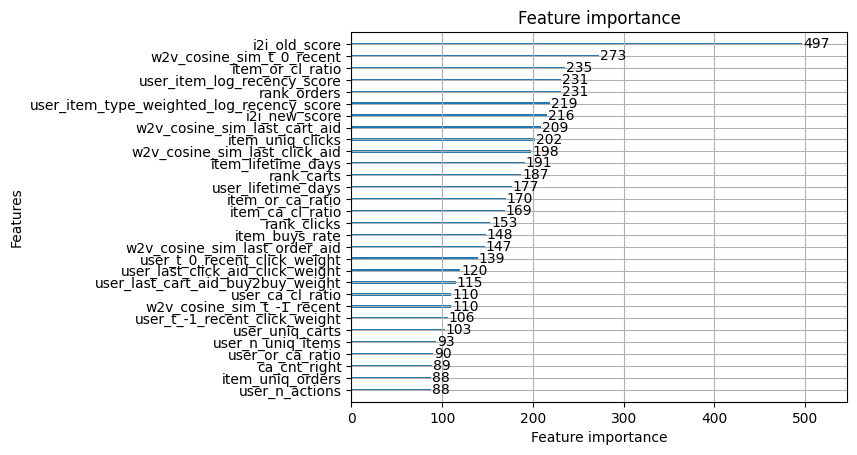

In [58]:
lgb.plot_importance(gbm_ranking, max_num_features=30)

## Simple train XGB

In [44]:
feature_cols = df_stage_2_dataset.drop(["session", "aid", "target"]).columns
print("num features: ", len(feature_cols))

num features:  49


In [47]:
skf = GroupKFold(n_splits=5)
df_valid_preds = df_stage_2_dataset.select(["session", "aid"])

for fold, (train_idx, valid_idx) in tqdm(enumerate(
    skf.split(df_stage_2_dataset,
              df_stage_2_dataset['target'],
              groups=df_stage_2_dataset['session'])
)):
    
    X_train = df_stage_2_dataset[train_idx][feature_cols].to_pandas()
    y_train = df_stage_2_dataset[train_idx]["target"].to_pandas()
    X_valid = df_stage_2_dataset[valid_idx][feature_cols].to_pandas()
    y_valid = df_stage_2_dataset[valid_idx]["target"].to_pandas()
    
    # create dataset for lightgbm
    groups_len_train = (
        df_stage_2_dataset[train_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )
    groups_len_valid = (
        df_stage_2_dataset[valid_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )

    dtrain = xgb.DMatrix(X_train, y_train, group=groups_len_train) 
    dvalid = xgb.DMatrix(X_valid, y_valid, group=groups_len_valid)

    xgb_params = {'objective':'rank:pairwise', 'tree_method':'gpu_hist'}
#     xgb_params = {'objective':'binary:logistic', 'tree_method':'gpu_hist'}
    model = xgb.train(xgb_params, 
        dtrain=dtrain,
        evals=[(dtrain,'train'),(dvalid,'valid')],
        num_boost_round=1000,
        verbose_eval=50)

0it [00:00, ?it/s]

[0]	train-map:0.75289	valid-map:0.75234
[50]	train-map:0.78662	valid-map:0.78428
[100]	train-map:0.79187	valid-map:0.78802
[150]	train-map:0.79406	valid-map:0.78854
[200]	train-map:0.79577	valid-map:0.78943
[250]	train-map:0.79699	valid-map:0.78971
[300]	train-map:0.79832	valid-map:0.78998
[350]	train-map:0.79961	valid-map:0.78985
[400]	train-map:0.80065	valid-map:0.79009
[450]	train-map:0.80195	valid-map:0.79013
[500]	train-map:0.80287	valid-map:0.79017
[550]	train-map:0.80405	valid-map:0.78998
[600]	train-map:0.80492	valid-map:0.79004
[650]	train-map:0.80602	valid-map:0.78985
[700]	train-map:0.80710	valid-map:0.78951
[750]	train-map:0.80786	valid-map:0.79004
[800]	train-map:0.80869	valid-map:0.78974
[850]	train-map:0.80959	valid-map:0.78970
[900]	train-map:0.81035	valid-map:0.78974
[950]	train-map:0.81095	valid-map:0.78981
[999]	train-map:0.81168	valid-map:0.78973


1it [02:11, 131.33s/it]

[0]	train-map:0.75477	valid-map:0.75508
[50]	train-map:0.78683	valid-map:0.78539
[100]	train-map:0.79153	valid-map:0.78834
[150]	train-map:0.79421	valid-map:0.78955
[200]	train-map:0.79569	valid-map:0.78998
[250]	train-map:0.79712	valid-map:0.79018
[300]	train-map:0.79830	valid-map:0.79034
[350]	train-map:0.79943	valid-map:0.79084
[400]	train-map:0.80067	valid-map:0.79077
[450]	train-map:0.80180	valid-map:0.79068
[500]	train-map:0.80272	valid-map:0.79097
[550]	train-map:0.80372	valid-map:0.79052
[600]	train-map:0.80425	valid-map:0.79026
[650]	train-map:0.80529	valid-map:0.79046
[700]	train-map:0.80641	valid-map:0.79051
[750]	train-map:0.80736	valid-map:0.79045
[800]	train-map:0.80837	valid-map:0.78990
[850]	train-map:0.80893	valid-map:0.79018
[900]	train-map:0.80993	valid-map:0.79014
[950]	train-map:0.81050	valid-map:0.78971
[999]	train-map:0.81147	valid-map:0.78953


2it [04:22, 131.22s/it]

[0]	train-map:0.75409	valid-map:0.75027
[50]	train-map:0.78678	valid-map:0.78138
[100]	train-map:0.79224	valid-map:0.78486
[150]	train-map:0.79469	valid-map:0.78631
[200]	train-map:0.79598	valid-map:0.78656
[250]	train-map:0.79714	valid-map:0.78675
[300]	train-map:0.79838	valid-map:0.78661
[350]	train-map:0.79992	valid-map:0.78677
[400]	train-map:0.80105	valid-map:0.78713
[450]	train-map:0.80204	valid-map:0.78691
[500]	train-map:0.80306	valid-map:0.78709
[550]	train-map:0.80417	valid-map:0.78698
[600]	train-map:0.80503	valid-map:0.78699
[650]	train-map:0.80606	valid-map:0.78687
[700]	train-map:0.80732	valid-map:0.78707
[750]	train-map:0.80800	valid-map:0.78686
[800]	train-map:0.80888	valid-map:0.78660
[850]	train-map:0.80946	valid-map:0.78689
[900]	train-map:0.81043	valid-map:0.78674
[950]	train-map:0.81107	valid-map:0.78657
[999]	train-map:0.81176	valid-map:0.78664


3it [06:33, 131.28s/it]

[0]	train-map:0.75260	valid-map:0.75370
[50]	train-map:0.78580	valid-map:0.78653
[100]	train-map:0.79126	valid-map:0.79076
[150]	train-map:0.79357	valid-map:0.79197
[200]	train-map:0.79515	valid-map:0.79213
[250]	train-map:0.79658	valid-map:0.79224
[300]	train-map:0.79773	valid-map:0.79222
[350]	train-map:0.79905	valid-map:0.79232
[400]	train-map:0.80023	valid-map:0.79241
[450]	train-map:0.80119	valid-map:0.79247
[500]	train-map:0.80204	valid-map:0.79218
[550]	train-map:0.80319	valid-map:0.79210
[600]	train-map:0.80409	valid-map:0.79206
[650]	train-map:0.80512	valid-map:0.79163
[700]	train-map:0.80616	valid-map:0.79140
[750]	train-map:0.80688	valid-map:0.79148
[800]	train-map:0.80778	valid-map:0.79142
[850]	train-map:0.80858	valid-map:0.79145
[900]	train-map:0.80957	valid-map:0.79082
[950]	train-map:0.81020	valid-map:0.79089
[999]	train-map:0.81097	valid-map:0.79114


4it [08:44, 131.13s/it]

[0]	train-map:0.75279	valid-map:0.75415
[50]	train-map:0.78612	valid-map:0.78609
[100]	train-map:0.79109	valid-map:0.78971
[150]	train-map:0.79380	valid-map:0.79061
[200]	train-map:0.79533	valid-map:0.79147
[250]	train-map:0.79665	valid-map:0.79171
[300]	train-map:0.79768	valid-map:0.79184
[350]	train-map:0.79894	valid-map:0.79195
[400]	train-map:0.80000	valid-map:0.79217
[450]	train-map:0.80116	valid-map:0.79177
[500]	train-map:0.80194	valid-map:0.79189
[550]	train-map:0.80323	valid-map:0.79176
[600]	train-map:0.80388	valid-map:0.79163
[650]	train-map:0.80512	valid-map:0.79151
[700]	train-map:0.80618	valid-map:0.79138
[750]	train-map:0.80684	valid-map:0.79162
[800]	train-map:0.80768	valid-map:0.79136
[850]	train-map:0.80873	valid-map:0.79102
[900]	train-map:0.80946	valid-map:0.79098
[950]	train-map:0.81028	valid-map:0.79110
[999]	train-map:0.81089	valid-map:0.79081


5it [10:55, 131.15s/it]


In [52]:
model.predict(dvalid)

(6693239,)

## Optuna time to find optimal params

In [48]:
import optuna

In [81]:
def fit_cv_xgb(params, callbacks=None):
    skf = GroupKFold(n_splits=5)
    df_valid_preds = df_candidates_all.select(["session", "aid"])

    for fold, (train_idx, valid_idx) in tqdm(enumerate(
        skf.split(df_stage_2_dataset,
                  df_stage_2_dataset['target'],
                  groups=df_stage_2_dataset['session'])
    )):

        X_train = df_stage_2_dataset[train_idx][feature_cols].to_pandas()
        y_train = df_stage_2_dataset[train_idx]["target"].to_pandas()
        X_valid = df_stage_2_dataset[valid_idx][feature_cols].to_pandas()
        y_valid = df_stage_2_dataset[valid_idx]["target"].to_pandas()

        # group lengths for ranking
        groups_len_train = (
            df_stage_2_dataset[train_idx]
            .groupby("session").agg(pl.count("aid"))
            .sort("session")["aid"].to_numpy()
        )
        groups_len_valid = (
            df_stage_2_dataset[valid_idx]
            .groupby("session").agg(pl.count("aid"))
            .sort("session")["aid"].to_numpy()
        )
        dtrain = xgb.DMatrix(X_train, y_train, group=groups_len_train) 
        dvalid = xgb.DMatrix(X_valid, y_valid, group=groups_len_valid)

        model = xgb.train(
            params, 
            dtrain=dtrain,
            evals=[(dvalid,'valid')],
            num_boost_round=2000,
            early_stopping_rounds=200,
            verbose_eval=100,
            callbacks=callbacks,
        )
    
        scores = model.predict(dvalid)
        df_valid_preds_fold = (
            df_stage_2_dataset[valid_idx].select(["session", "aid"])
            .with_columns([pl.Series(scores).alias(f"scores_fold{fold}")])
        )
        df_valid_preds = df_valid_preds.join(df_valid_preds_fold, on=["session", "aid"], how="left")
    
    return df_valid_preds

In [82]:
def objective(trial: optuna.Trial):
    
    params = {
        "verbosity": 0,
        'objective':'rank:pairwise',
        "eval_metric": "map@20",
        'tree_method':'gpu_hist',
        "gpu_id": 1,
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        
        "subsample": 0.8,
        "sampling_method": "gradient_based",
    }
    
    params["max_depth"] = trial.suggest_int("max_depth", 5, 9)
    params["eta"] = trial.suggest_float("eta", 1e-3, 0.5, log=True)
    params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "valid-map@20")
    df_valid_preds = fit_cv_xgb(params, callbacks=[pruning_callback])
    
    # get oof recs and calc recall
    scores = (
        df_valid_preds
        .select([
            pl.col("scores_fold0"),
            pl.col("scores_fold1"),
            pl.col("scores_fold2"), 
            pl.col("scores_fold3"), 
            pl.col("scores_fold4"),
        ]).mean(axis=1)
    )
    
    df_valid_preds_sorted = (
        df_valid_preds
        .with_columns([pl.Series(scores).alias("score")])
        .sort("score", reverse=True)
        .groupby("session")
        .agg([
            pl.list("aid"),
            pl.list("score"),
        ])
    )
    
    df_recall = (
        df_valid_preds_sorted
        .join(val_df_valid_targets_orders, on="session", how="inner")
        .with_column(pl.col("aid").arr.head(20).alias("label"))
        .with_column(
            pl.col("label")
            .arr.concat("ground_truth")
            .arr.eval(pl.element().filter(pl.count().over(pl.element()) == 2))
            .arr.unique()
            .alias("hits")
        )
        .with_column(pl.col("hits").arr.lengths().clip(0, 20).alias("hits_count"))
        .with_column(pl.col("ground_truth").arr.lengths().clip(0, 20).alias("gt_count"))
    )
    
    recall = df_recall["hits_count"].sum() / df_recall["gt_count"].sum()
    return recall


In [ ]:
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
study = optuna.create_study(pruner=pruner, direction="maximize")
study.optimize(objective, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-01-29 08:19:56,550] A new study created in memory with name: no-name-dd95ff3b-475d-447e-bf4f-d6830527b830
0it [00:00, ?it/s]

[0]	valid-map@20:0.75368
[100]	valid-map@20:0.78627
[200]	valid-map@20:0.78643
[300]	valid-map@20:0.78535
[327]	valid-map@20:0.78507


1it [00:53, 53.99s/it]

[0]	valid-map@20:0.75555
[100]	valid-map@20:0.78783
[200]	valid-map@20:0.78669
[298]	valid-map@20:0.78541


2it [01:45, 52.41s/it]

[0]	valid-map@20:0.75300
[100]	valid-map@20:0.78408
[200]	valid-map@20:0.78322
[300]	valid-map@20:0.78250
[329]	valid-map@20:0.78241


3it [02:41, 54.03s/it]

[0]	valid-map@20:0.75691
[100]	valid-map@20:0.78957
[200]	valid-map@20:0.78806
[300]	valid-map@20:0.78704
[310]	valid-map@20:0.78709


4it [03:34, 53.72s/it]

[0]	valid-map@20:0.75703
[100]	valid-map@20:0.78820
[200]	valid-map@20:0.78761
[300]	valid-map@20:0.78693
[336]	valid-map@20:0.78655


5it [04:31, 54.23s/it]
[I 2023-01-29 08:24:54,682] Trial 0 finished with value: 0.6503031942941193 and parameters: {'lambda': 0.0012329423754643327, 'alpha': 0.0012262134432874563, 'max_depth': 7, 'eta': 0.47704648954754, 'gamma': 0.09418712925497813, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.6503031942941193.
0it [00:00, ?it/s]

[0]	valid-map@20:0.75369
[100]	valid-map@20:0.76212
[200]	valid-map@20:0.76562
[300]	valid-map@20:0.76915
[400]	valid-map@20:0.77254
[500]	valid-map@20:0.77648
[600]	valid-map@20:0.77840
[700]	valid-map@20:0.78006
[800]	valid-map@20:0.78117
[900]	valid-map@20:0.78214
[1000]	valid-map@20:0.78308
[1100]	valid-map@20:0.78361
[1200]	valid-map@20:0.78411
[1300]	valid-map@20:0.78486
[1400]	valid-map@20:0.78528
[1500]	valid-map@20:0.78589
[1600]	valid-map@20:0.78608
[1700]	valid-map@20:0.78632
[1800]	valid-map@20:0.78660
[1900]	valid-map@20:0.78671
[1999]	valid-map@20:0.78700


1it [05:09, 309.75s/it]

[0]	valid-map@20:0.75555
[100]	valid-map@20:0.76283
[200]	valid-map@20:0.76630
[300]	valid-map@20:0.77023
[400]	valid-map@20:0.77402
[500]	valid-map@20:0.77784
[600]	valid-map@20:0.77918
[700]	valid-map@20:0.78072
[800]	valid-map@20:0.78167
[900]	valid-map@20:0.78242
[1000]	valid-map@20:0.78324
[1100]	valid-map@20:0.78395
[1200]	valid-map@20:0.78458
[1300]	valid-map@20:0.78512
[1400]	valid-map@20:0.78549
[1500]	valid-map@20:0.78585
[1600]	valid-map@20:0.78635
[1700]	valid-map@20:0.78656
[1800]	valid-map@20:0.78686
[1900]	valid-map@20:0.78697
[1999]	valid-map@20:0.78728


2it [10:20, 310.50s/it]

[0]	valid-map@20:0.75300
[100]	valid-map@20:0.76182
[200]	valid-map@20:0.76413
[300]	valid-map@20:0.76722
[400]	valid-map@20:0.77083
[500]	valid-map@20:0.77431
[600]	valid-map@20:0.77600
[700]	valid-map@20:0.77732
[800]	valid-map@20:0.77813
[900]	valid-map@20:0.77887
[1000]	valid-map@20:0.77961
[1100]	valid-map@20:0.78035
[1200]	valid-map@20:0.78109
[1300]	valid-map@20:0.78147
[1400]	valid-map@20:0.78223
[1500]	valid-map@20:0.78263
[1600]	valid-map@20:0.78287
[1700]	valid-map@20:0.78337
[1800]	valid-map@20:0.78353
[1900]	valid-map@20:0.78362
[1999]	valid-map@20:0.78401


3it [15:31, 310.60s/it]

[0]	valid-map@20:0.75691
[100]	valid-map@20:0.76487
[200]	valid-map@20:0.76844
[300]	valid-map@20:0.77147
[400]	valid-map@20:0.77547
[500]	valid-map@20:0.77880
[600]	valid-map@20:0.78107
[700]	valid-map@20:0.78250
[800]	valid-map@20:0.78325
[900]	valid-map@20:0.78418
[1000]	valid-map@20:0.78519
[1100]	valid-map@20:0.78609
[1200]	valid-map@20:0.78698
[1300]	valid-map@20:0.78774
[1400]	valid-map@20:0.78806
[1500]	valid-map@20:0.78877
[1600]	valid-map@20:0.78909
[1700]	valid-map@20:0.78943
[1800]	valid-map@20:0.78972
[1900]	valid-map@20:0.78996
[1999]	valid-map@20:0.79013


4it [20:42, 310.92s/it]

[0]	valid-map@20:0.75701
[100]	valid-map@20:0.76560
[200]	valid-map@20:0.76825
[300]	valid-map@20:0.77179
[400]	valid-map@20:0.77467
[500]	valid-map@20:0.77864
[600]	valid-map@20:0.78103
[700]	valid-map@20:0.78237
[800]	valid-map@20:0.78284
[900]	valid-map@20:0.78352
[1000]	valid-map@20:0.78440
[1100]	valid-map@20:0.78522
[1200]	valid-map@20:0.78591
[1300]	valid-map@20:0.78635
[1400]	valid-map@20:0.78679
[1500]	valid-map@20:0.78716
[1600]	valid-map@20:0.78768
[1700]	valid-map@20:0.78809
[1800]	valid-map@20:0.78833
[1900]	valid-map@20:0.78853
[1999]	valid-map@20:0.78850


5it [25:52, 310.54s/it]
[I 2023-01-29 08:51:13,997] Trial 1 finished with value: 0.6567070463186524 and parameters: {'lambda': 0.0009634010918507909, 'alpha': 0.00013223636622598109, 'max_depth': 7, 'eta': 0.010095500053950705, 'gamma': 0.00010263638195744149, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.6567070463186524.
0it [00:00, ?it/s]

[0]	valid-map@20:0.75483
[100]	valid-map@20:0.77902
[200]	valid-map@20:0.78514
[300]	valid-map@20:0.78717
[400]	valid-map@20:0.78810
[500]	valid-map@20:0.78874
[600]	valid-map@20:0.78902
[700]	valid-map@20:0.78902
[800]	valid-map@20:0.78913
[900]	valid-map@20:0.78914
[1000]	valid-map@20:0.78915
[1100]	valid-map@20:0.78911
[1200]	valid-map@20:0.78923
[1300]	valid-map@20:0.78901
[1342]	valid-map@20:0.78908


1it [03:36, 216.03s/it]

[0]	valid-map@20:0.76101
[100]	valid-map@20:0.77973
[200]	valid-map@20:0.78509
[300]	valid-map@20:0.78752
[400]	valid-map@20:0.78856
[500]	valid-map@20:0.78950
[600]	valid-map@20:0.78965
[700]	valid-map@20:0.78970
[800]	valid-map@20:0.78981
[900]	valid-map@20:0.78954
[923]	valid-map@20:0.78938


2it [06:11, 180.43s/it]

[0]	valid-map@20:0.75966
[100]	valid-map@20:0.77591
[200]	valid-map@20:0.78185
[300]	valid-map@20:0.78471
[400]	valid-map@20:0.78534
[500]	valid-map@20:0.78629
[600]	valid-map@20:0.78665
[700]	valid-map@20:0.78682
[800]	valid-map@20:0.78716
[900]	valid-map@20:0.78698
[1000]	valid-map@20:0.78703
[1100]	valid-map@20:0.78707
[1158]	valid-map@20:0.78713


3it [09:22, 185.10s/it]

[0]	valid-map@20:0.76165
[100]	valid-map@20:0.78108
[200]	valid-map@20:0.78722
[300]	valid-map@20:0.78990
[400]	valid-map@20:0.79111
[500]	valid-map@20:0.79143
[600]	valid-map@20:0.79132
[700]	valid-map@20:0.79157
[800]	valid-map@20:0.79166
[900]	valid-map@20:0.79139
[1000]	valid-map@20:0.79151
[1100]	valid-map@20:0.79165
[1183]	valid-map@20:0.79156


4it [12:36, 188.58s/it]

[0]	valid-map@20:0.76351
[100]	valid-map@20:0.78100
[200]	valid-map@20:0.78652
[300]	valid-map@20:0.78889
[400]	valid-map@20:0.78964
[500]	valid-map@20:0.79008
[600]	valid-map@20:0.79047
[700]	valid-map@20:0.79058
[800]	valid-map@20:0.79090
[900]	valid-map@20:0.79063
[989]	valid-map@20:0.79057


5it [15:21, 184.24s/it]
[I 2023-01-29 09:07:01,926] Trial 2 finished with value: 0.6550210917769822 and parameters: {'lambda': 7.492602274207669e-05, 'alpha': 0.008440159064482585, 'max_depth': 8, 'eta': 0.047707696019001995, 'gamma': 0.97855643199289, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.6567070463186524.
0it [00:00, ?it/s]

[0]	valid-map@20:0.75483
[100]	valid-map@20:0.77309
[200]	valid-map@20:0.78040
[300]	valid-map@20:0.78385
[400]	valid-map@20:0.78606
[500]	valid-map@20:0.78723
[600]	valid-map@20:0.78804
[700]	valid-map@20:0.78836
[800]	valid-map@20:0.78850
[900]	valid-map@20:0.78890
[1000]	valid-map@20:0.78916
[1100]	valid-map@20:0.78901
[1144]	valid-map@20:0.78899


1it [03:05, 185.18s/it]

[0]	valid-map@20:0.76101
[100]	valid-map@20:0.77460
[200]	valid-map@20:0.78168
[300]	valid-map@20:0.78426
[400]	valid-map@20:0.78630
[500]	valid-map@20:0.78760
[600]	valid-map@20:0.78817
[700]	valid-map@20:0.78876
[800]	valid-map@20:0.78919
[900]	valid-map@20:0.78961
[1000]	valid-map@20:0.78977
[1100]	valid-map@20:0.78987
[1200]	valid-map@20:0.79003
[1300]	valid-map@20:0.79016
[1400]	valid-map@20:0.79001
[1500]	valid-map@20:0.78995
[1569]	valid-map@20:0.78966


2it [07:11, 220.98s/it]

[0]	valid-map@20:0.75966
[100]	valid-map@20:0.77135
[200]	valid-map@20:0.77732
[300]	valid-map@20:0.78054
[400]	valid-map@20:0.78311
[500]	valid-map@20:0.78427
[600]	valid-map@20:0.78540
[700]	valid-map@20:0.78542
[800]	valid-map@20:0.78577
[900]	valid-map@20:0.78625
[1000]	valid-map@20:0.78656
[1100]	valid-map@20:0.78660
[1200]	valid-map@20:0.78669
[1300]	valid-map@20:0.78684
[1400]	valid-map@20:0.78690
[1500]	valid-map@20:0.78682
[1600]	valid-map@20:0.78713
[1700]	valid-map@20:0.78698
[1800]	valid-map@20:0.78716
[1900]	valid-map@20:0.78719
[1999]	valid-map@20:0.78724


3it [12:16, 259.69s/it]

[0]	valid-map@20:0.76165
[100]	valid-map@20:0.77591
[200]	valid-map@20:0.78299
[300]	valid-map@20:0.78652
[400]	valid-map@20:0.78839
[500]	valid-map@20:0.78990
[600]	valid-map@20:0.79092
[700]	valid-map@20:0.79121
[800]	valid-map@20:0.79113
[900]	valid-map@20:0.79150
[1000]	valid-map@20:0.79163
[1100]	valid-map@20:0.79178
[1200]	valid-map@20:0.79192
[1300]	valid-map@20:0.79207
[1400]	valid-map@20:0.79221
[1500]	valid-map@20:0.79235
[1600]	valid-map@20:0.79211
[1700]	valid-map@20:0.79226
[1760]	valid-map@20:0.79209


4it [16:48, 264.53s/it]

[0]	valid-map@20:0.76154
[100]	valid-map@20:0.77568
[200]	valid-map@20:0.78288
[300]	valid-map@20:0.78617
[400]	valid-map@20:0.78762
[500]	valid-map@20:0.78872
[600]	valid-map@20:0.78950
[700]	valid-map@20:0.78984
[800]	valid-map@20:0.78997
[900]	valid-map@20:0.79015
[1000]	valid-map@20:0.79042
[1100]	valid-map@20:0.79063
[1200]	valid-map@20:0.79087
[1300]	valid-map@20:0.79088
[1400]	valid-map@20:0.79089
[1427]	valid-map@20:0.79088


5it [20:33, 246.76s/it]
[I 2023-01-29 09:28:02,766] Trial 3 finished with value: 0.6554859434407349 and parameters: {'lambda': 0.003304436094342764, 'alpha': 0.0016404381771581151, 'max_depth': 8, 'eta': 0.0280840420053276, 'gamma': 2.7892538280087338e-08, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.6567070463186524.
0it [00:00, ?it/s]

[0]	valid-map@20:0.74916
[100]	valid-map@20:0.75793
[200]	valid-map@20:0.75938
[300]	valid-map@20:0.76331
[400]	valid-map@20:0.76850
[500]	valid-map@20:0.77243
[600]	valid-map@20:0.77382
[700]	valid-map@20:0.77511
[800]	valid-map@20:0.77646
[900]	valid-map@20:0.77713
[1000]	valid-map@20:0.77829
[1100]	valid-map@20:0.77937
[1200]	valid-map@20:0.78036
[1300]	valid-map@20:0.78111
[1400]	valid-map@20:0.78164
[1500]	valid-map@20:0.78208
[1600]	valid-map@20:0.78244
[1700]	valid-map@20:0.78271
[1800]	valid-map@20:0.78304
[1900]	valid-map@20:0.78348
[1999]	valid-map@20:0.78379


1it [04:45, 285.60s/it]

[0]	valid-map@20:0.74933
[100]	valid-map@20:0.75793
[200]	valid-map@20:0.75953
[300]	valid-map@20:0.76386
[400]	valid-map@20:0.76909
[500]	valid-map@20:0.77320
[600]	valid-map@20:0.77436
[700]	valid-map@20:0.77545
[800]	valid-map@20:0.77645
[900]	valid-map@20:0.77749
[1000]	valid-map@20:0.77877
[1100]	valid-map@20:0.77978
[1200]	valid-map@20:0.78053
[1300]	valid-map@20:0.78128
[1400]	valid-map@20:0.78178
[1500]	valid-map@20:0.78241
[1600]	valid-map@20:0.78281
[1700]	valid-map@20:0.78328
[1800]	valid-map@20:0.78344
[1900]	valid-map@20:0.78375
[1999]	valid-map@20:0.78395


2it [09:32, 286.57s/it]

[0]	valid-map@20:0.74635
[100]	valid-map@20:0.75645
[200]	valid-map@20:0.75720
[300]	valid-map@20:0.76160
[400]	valid-map@20:0.76622
[500]	valid-map@20:0.76994
[600]	valid-map@20:0.77093
[700]	valid-map@20:0.77207
[800]	valid-map@20:0.77358
[900]	valid-map@20:0.77451
[1000]	valid-map@20:0.77562
[1100]	valid-map@20:0.77665
[1200]	valid-map@20:0.77723
[1300]	valid-map@20:0.77808
[1400]	valid-map@20:0.77867
[1500]	valid-map@20:0.77916
[1600]	valid-map@20:0.77956
[1700]	valid-map@20:0.77998
[1800]	valid-map@20:0.78046
[1900]	valid-map@20:0.78097
[1999]	valid-map@20:0.78124


3it [14:19, 286.46s/it]

[0]	valid-map@20:0.75056
[100]	valid-map@20:0.75822
[200]	valid-map@20:0.76077
[300]	valid-map@20:0.76622
[400]	valid-map@20:0.77155
[500]	valid-map@20:0.77557
[600]	valid-map@20:0.77615
[700]	valid-map@20:0.77736
[800]	valid-map@20:0.77820
[900]	valid-map@20:0.77915
[1000]	valid-map@20:0.78003
[1100]	valid-map@20:0.78113
[1200]	valid-map@20:0.78252
[1300]	valid-map@20:0.78312
[1400]	valid-map@20:0.78413
[1500]	valid-map@20:0.78460
[1600]	valid-map@20:0.78502
[1700]	valid-map@20:0.78560
[1800]	valid-map@20:0.78607
[1900]	valid-map@20:0.78653
[1999]	valid-map@20:0.78681


4it [19:07, 287.10s/it]

[0]	valid-map@20:0.75122
[100]	valid-map@20:0.76108
[200]	valid-map@20:0.76206
[300]	valid-map@20:0.76664
[400]	valid-map@20:0.77004
[500]	valid-map@20:0.77408
[600]	valid-map@20:0.77511
[700]	valid-map@20:0.77628
[800]	valid-map@20:0.77730
[900]	valid-map@20:0.77840
[1000]	valid-map@20:0.77939
[1100]	valid-map@20:0.78058
[1200]	valid-map@20:0.78147
[1300]	valid-map@20:0.78231
[1400]	valid-map@20:0.78301
[1500]	valid-map@20:0.78358
[1600]	valid-map@20:0.78399
[1700]	valid-map@20:0.78468
[1800]	valid-map@20:0.78503
[1900]	valid-map@20:0.78537
[1999]	valid-map@20:0.78558


5it [23:52, 286.60s/it]
[I 2023-01-29 09:52:22,543] Trial 4 finished with value: 0.6564711514445092 and parameters: {'lambda': 3.3819759217424226e-08, 'alpha': 0.003868248022545784, 'max_depth': 6, 'eta': 0.00964532776467944, 'gamma': 2.724573290260195e-07, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.6567070463186524.
0it [00:00, ?it/s]

[0]	valid-map@20:0.76077


0it [00:13, ?it/s]
[I 2023-01-29 09:52:36,358] Trial 5 pruned. Trial was pruned at iteration 19.
0it [00:00, ?it/s]

In [77]:
print("Best trial:")
trial = study.best_trial

Best trial:


In [56]:
val_df_valid_targets_orders = val_df_valid_targets.filter(pl.col("type") == "orders")

In [71]:
(
    val_df_valid_targets_orders
    .with_columns([pl.col("ground_truth").arr.head(2).alias("labels")])
    .with_column(pl.col("ground_truth").arr.lengths().clip(0, 20).alias("gt_count"))
)

20

In [ ]:
import optuna

import sklearn.datasets
import xgboost as xgb


def objective(trial):
    train_x, train_y = sklearn.datasets.load_breast_cancer(return_X_y=True)
    dtrain = xgb.DMatrix(train_x, label=train_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-auc")
    history = xgb.cv(param, dtrain, num_boost_round=100, callbacks=[pruning_callback])

    mean_auc = history["test-auc-mean"].values[-1]
    return mean_auc


if __name__ == "__main__":
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    study = optuna.create_study(pruner=pruner, direction="maximize")
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [2]:
import xgboost as xgb

In [10]:
import numpy as np


X = np.random.randn(1000000, 20)
y = np.random.randint(2, size=(1000000))

In [14]:
from sklearn.model_selection import GroupKFold, StratifiedKFold

skf = GroupKFold(n_splits=5)
skf = StratifiedKFold(n_splits=5)

In [16]:
for fold,(train_idx, valid_idx) in enumerate(skf.split(X, y)):

    X_train = X[train_idx, :]
    y_train = y[train_idx]
    X_valid = X[valid_idx, :]
    y_valid = y[valid_idx]

    # IF YOU HAVE 50 CANDIDATE WE USE 50 BELOW
#     dtrain = xgb.DMatrix(X_train, y_train, group=[50] * (len(train_idx)//50) ) 
#     dvalid = xgb.DMatrix(X_valid, y_valid, group=[50] * (len(valid_idx)//50) ) 
    dtrain = xgb.DMatrix(X_train, y_train, ) 
    dvalid = xgb.DMatrix(X_valid, y_valid)

    xgb_params = {'objective':'rank:pairwise', 'tree_method':'gpu_hist'}
    xgb_params = {'objective':'binary:logistic', 'tree_method':'gpu_hist'}
    model = xgb.train(xgb_params, 
        dtrain=dtrain,
        evals=[(dtrain,'train'),(dvalid,'valid')],
        num_boost_round=1000,
        verbose_eval=100)

[0]	train-logloss:0.69296	valid-logloss:0.69314
[100]	train-logloss:0.67820	valid-logloss:0.69609
[200]	train-logloss:0.66506	valid-logloss:0.69876
[300]	train-logloss:0.65249	valid-logloss:0.70157
[400]	train-logloss:0.64069	valid-logloss:0.70406
[500]	train-logloss:0.62922	valid-logloss:0.70631
[600]	train-logloss:0.61819	valid-logloss:0.70854
[700]	train-logloss:0.60735	valid-logloss:0.71085
[800]	train-logloss:0.59710	valid-logloss:0.71314
[900]	train-logloss:0.58684	valid-logloss:0.71549
[999]	train-logloss:0.57724	valid-logloss:0.71763
[0]	train-logloss:0.69299	valid-logloss:0.69318
[100]	train-logloss:0.67841	valid-logloss:0.69607
[200]	train-logloss:0.66529	valid-logloss:0.69851
[300]	train-logloss:0.65313	valid-logloss:0.70072
[400]	train-logloss:0.64115	valid-logloss:0.70329
[500]	train-logloss:0.62992	valid-logloss:0.70526
[600]	train-logloss:0.61905	valid-logloss:0.70752
[700]	train-logloss:0.60828	valid-logloss:0.70984
[800]	train-logloss:0.59792	valid-logloss:0.71230
[900

In [ ]:
import optuna